In [40]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sodapy import Socrata

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
creds_file = open('./creds.json', 'r')
socrata_creds = json.loads(creds_file.read())

In [7]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", socrata_creds['app_token'])

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# Data
---

### DHS Daily Report
Source: https://data.cityofnewyork.us/Social-Services/DHS-Daily-Report/k46n-sa2m

This dataset includes the daily number of families and individuals residing in the Department of Homeless Services (DHS) shelter system and the daily number of families applying to the DHS shelter system.

In [20]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("k46n-sa2m", limit = 10_000);

# Convert to pandas DataFrame
daily_df = pd.DataFrame.from_records(results);

In [9]:
def adf(series_to_try):
    """
    a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
    """
    dftest = adfuller(series_to_try)
    result = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return result

In [10]:
def acf_pacf(series_to_plot, n_lag):
    """
    Plot ACF & PACF
    """
    plot_acf(series_to_plot, lags = n_lag);
    plt.ylabel('autocorrelation')
    plt.xlabel('lags');

    plot_pacf(series_to_plot, lags = n_lag);
    plt.ylabel('partial autocorrelation')
    plt.xlabel('lags');

In [11]:
def evaluate(data_to_evaluate, residual):
    
    """
    make residual graphs and print out MSE 
    """

    plt.figure(figsize = (12,5))
    plt.scatter(data_to_evaluate.index, residual)
    plt.title('Residuals')
    plt.axhline(0, color='red')

    return {"mean square error": sum(np.square(residual)) / len(residual)}

# Data Cleaning

The type of all columns is 'object'. `date_of_census` is datetime column and rest of the columns are numerical column. Change the types appropriately.

In [21]:
daily_df['date_of_census'] = daily_df['date_of_census'].apply(lambda x: x.split('T')[0])

In [22]:
daily_df.index = pd.to_datetime(daily_df['date_of_census'], format = "%Y/%m/%d")
daily_df = daily_df.drop('date_of_census', axis = 1)

In [23]:
daily_df = daily_df.apply(pd.to_numeric)

In [24]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2219 entries, 2019-11-19 to 2013-08-21
Data columns (total 12 columns):
total_adults_in_shelter                                    2219 non-null int64
total_children_in_shelter                                  2219 non-null int64
total_individuals_in_shelter                               2219 non-null int64
single_adult_men_in_shelter                                2219 non-null int64
single_adult_women_in_shelter                              2219 non-null int64
total_single_adults_in_shelter                             2219 non-null int64
families_with_children_in_shelter                          2219 non-null int64
adults_in_families_with_children_in_shelter                2219 non-null int64
children_in_families_with_children_in_shelter              2219 non-null int64
total_individuals_in_families_with_children_in_shelter_    2219 non-null int64
adult_families_in_shelter                                  2219 non-null int64
indivi

In [25]:
weekly_df = daily_df.resample('W').mean()

# RNN Modeling (Multivariate timeseries)
- `weekly_comb.csv` dataset

In [64]:
weekly_comb = pd.read_csv("./homeless/weekly_comb.csv")

In [65]:
weekly_comb.head()

,project_start_date,reporting_construction_type,extended_affordability_status,extremely_low_income_units,very_low_income_units,low_income_units,moderate_income_units,middle_income_units,all_counted_units,total_units,...,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,total_individuals_in_families_with_children_in_shelter_,adult_families_in_shelter,individuals_in_adult_families_in_shelter
0,2014-01-05,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,...,50956.000000,7343.000000,2684.666667,10027.666667,10514.333333,14963.333333,21992.000000,36955.333333,1874.333333,3973.000000
1,2014-01-12,0.285714,0.000000,0.0,0.000000,0.142857,0.000000,0.285714,0.428571,0.428571,...,51157.571429,7387.714286,2719.428571,10107.142857,10539.714286,15002.857143,22071.428571,37074.285714,1874.142857,3976.142857
2,2014-01-19,0.571429,0.000000,0.0,22.285714,17.571429,0.000000,0.428571,40.857143,40.857143,...,51355.857143,7375.000000,2759.571429,10134.571429,10596.714286,15075.571429,22176.857143,37252.428571,1873.142857,3968.857143
3,2014-01-26,1.142857,0.142857,0.0,0.142857,26.000000,1.428571,0.142857,28.142857,28.142857,...,51840.000000,7505.714286,2797.285714,10303.000000,10672.714286,15188.571429,22342.285714,37530.857143,1892.714286,4006.142857
4,2014-02-02,0.428571,0.000000,0.0,4.000000,16.142857,0.000000,0.428571,20.714286,20.714286,...,52017.857143,7478.857143,2775.714286,10254.571429,10735.857143,15287.571429,22475.000000,37762.571429,1891.285714,4000.714286


In [66]:
weekly_comb.index = pd.to_datetime(weekly_comb['project_start_date'], format = "%Y/%m/%d")
weekly_comb = weekly_comb.drop('project_start_date', axis = 1)

In [67]:
weekly_comb.head(2)

,reporting_construction_type,extended_affordability_status,extremely_low_income_units,very_low_income_units,low_income_units,moderate_income_units,middle_income_units,all_counted_units,total_units,total_adults_in_shelter,...,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,total_individuals_in_families_with_children_in_shelter_,adult_families_in_shelter,individuals_in_adult_families_in_shelter
project_start_date,,,,,,,,,,,,,,,,,,,,,
2014-01-05,0.333333,0.0,0.0,0.0,0.000000,0.0,0.333333,0.333333,0.333333,28964.000000,...,50956.000000,7343.000000,2684.666667,10027.666667,10514.333333,14963.333333,21992.000000,36955.333333,1874.333333,3973.000000
2014-01-12,0.285714,0.0,0.0,0.0,0.142857,0.0,0.285714,0.428571,0.428571,29086.142857,...,51157.571429,7387.714286,2719.428571,10107.142857,10539.714286,15002.857143,22071.428571,37074.285714,1874.142857,3976.142857


In [72]:
df = weekly_comb[['total_individuals_in_shelter', 'all_counted_units']]

In [74]:
# Create X and y
X = df.drop(columns = 'total_individuals_in_shelter')
y = df['all_counted_units'].values # with Keras, target should be `array`!!

In [75]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle =False)

In [76]:
# Scale

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [77]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train,
                                      length = 3,
                                      batch_size = 128)

In [81]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                     length = 3,
                                     batch_size = 128)

In [86]:
train_sequences[0][0].shape

(128, 3, 1)

In [87]:
# Design RNN
model = Sequential()

# Don't set the activation fn for RNN (tanh is defualt)
model.add(GRU(8,
              dropout = 0.2, # X_samples
              recurrent_dropout = 0.2, # state from previous step
              input_shape = (3, 1), # implicitly setting the input layer
              return_sequences = True)) # True is the NEXT layer is RNNs

model.add(GRU(8,
              return_sequences = False)) # False if the NEXT layer is DENSE

model.add(Dropout(0.2)) # bad AFTER RNNs (set dropout and recurrent_dropout instead)

model.add(Dense(4,
                activation = 'relu'))

model.add(Dropout(0.2)) # good AFTER Dense

# For binary classification
# 1 neuron, sigmoid activation fn
model.add(Dense(1,
                activation = 'sigmoid'))

In [88]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

In [89]:
hist = model.fit_generator(train_sequences,
                    epochs = 20,
                    validation_data = test_sequences,
                    verbose = 0)

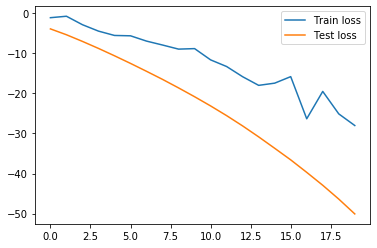

In [90]:
# Plot out our train/test loss curves

plt.plot(hist.history['loss'], label = 'Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend();

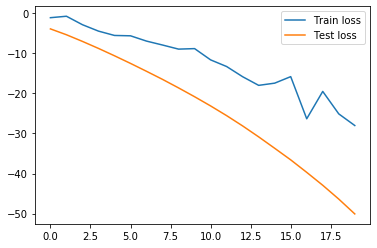

In [91]:
# Plot out our train/test loss curves

plt.plot(hist.history['loss'], label = 'Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend();

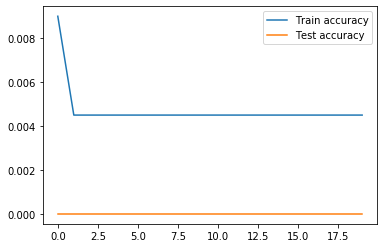

In [92]:
# Plot out our train/test loss curves

plt.plot(hist.history['accuracy'], label = 'Train accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Test accuracy')
plt.legend();

In [176]:
model.evaluate_generator(test_sequences)
trainPredict = model.predict_generator(train_sequences)
testPredict = model.predict_generator(test_sequences)

In [213]:
inverse_sc_trainPredict = ss.inverse_transform(trainPredict)
inverse_sc_testPredict = ss.inverse_transform(testPredict)

In [214]:
test_predict=[]
for arr in list(inverse_sc_testPredict):
    test_predict.append(arr[0])

In [215]:
train_predict=[]
for arr in list(inverse_sc_trainPredict):
    train_predict.append(arr[0])

In [216]:
original_train_preds = np.cumsum([df['total_individuals_in_shelter'].iloc[3-1]] + train_predict)
original_test_preds = np.cumsum([df['total_individuals_in_shelter'].iloc[len(y_train)+3-1]] + test_predict)

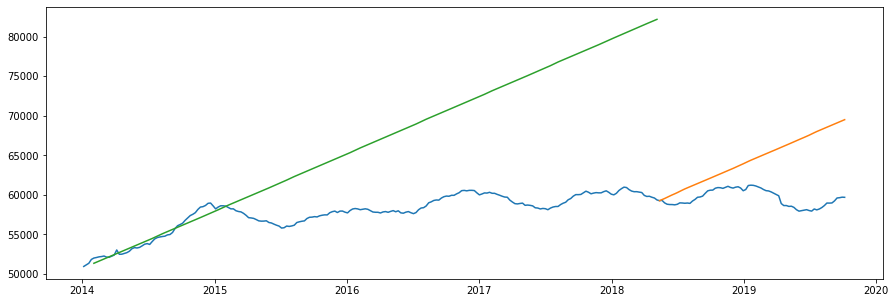

In [219]:
plt.figure(figsize = (15,5))
plt.plot(df['total_individuals_in_shelter'])
plt.plot(df.index[-74:], original_test_preds)
plt.plot(df.index[4:-74], original_train_preds)

# RNN Modeling (Univariate timeseries)

In [31]:
adf(weekly_df['total_individuals_in_shelter'].diff(1).dropna())

Test Statistic   -4.649787
p-value           0.000104
dtype: float64

In [35]:
weekly_diff = weekly_df[['total_individuals_in_shelter']].diff(1).dropna()

In [48]:
train, test = train_test_split(weekly_diff[['total_individuals_in_shelter']],
                               test_size = 0.25,
                               shuffle = False)

In [49]:
train.shape

(244, 1)

In [50]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(train)
X_test_sc = ss.transform(test)

In [52]:
train_sequences = TimeseriesGenerator(train,
                                      targets = ['total_individual_in_shelter'],
                                      length = 3,
                                      batch_size = 128)

ValueError: Data and targets have to be of same length. Data length is 244 while target length is 1